# Estimation des paramètres

In [10]:
import utilities
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import spacy
import re
import sklearn
import random
import textdistance

from spacy.vocab               import Vocab
from spacy.language            import Language
from spacy.tokens              import Token
from spacymoji                 import Emoji
from   sklearn.tree            import DecisionTreeClassifier
from   sklearn.model_selection import train_test_split
from sklearn                   import metrics
from sklearn.model_selection   import GridSearchCV
from sklearn.metrics           import confusion_matrix
from sklearn.metrics           import roc_curve


In [11]:
nlp = spacy.load("en_core_web_sm")

@Language.component("hashtag")
def hashtag_pipe(
    doc: spacy.tokens.Doc
) -> spacy.tokens.Doc:
    """
    A spaCy pipeline component that merges tokens of the form #word into a single token.

    Parameters
    ----------
    doc : spacy.tokens.Doc
        The input spaCy Doc object to process.

    Returns
    -------
    spacy.tokens.Doc
        The processed spaCy Doc object with hashtags merged into a single token.
    """
    len_doc = -1
    for token in doc:
        len_doc=len_doc+1
    merged_hashtag = False
    while True:
        for token in doc:
            if token.text == '#':
                if(token.head is not None and token.i!=len_doc):
                    start_index = token.i
                    end_index = start_index + 1
                    with doc.retokenize() as retokenizer:
                        retokenizer.merge(doc[start_index:end_index+1])
                        merged_hashtag = True
                        break
        if not merged_hashtag:
            break
        merged_hashtag = False
    return doc

nlp.add_pipe("emoji", first=True)
nlp.add_pipe("hashtag", first=True)
Token.set_extension("is_hashtag", getter=lambda token: token.text[0] in ("#"), force=True)

Importation du corpus.

In [12]:
corpus = pd.read_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel10k.csv", sep=";", parse_dates=["publication_time"])

# on récupére les posts en anglais
mask = corpus["language"] == 'en'
corpus = corpus.loc[mask]
chanel = corpus['text'].tolist()
publication_time_chanel = corpus['publication_time'].tolist()

print(f"# documents in corpus: {len(chanel)}")

# documents in corpus: 1802


In [16]:
### temp ajout de lignes






chanel_junk_valid_new = pd.read_excel('C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel_junk_valid_new.xlsx')

# Extraire les éléments uniques de la colonne 'text' de chanel_junk_valid_new
existing_texts = set(chanel_junk_valid_new['text'])

# Filtrer les éléments de la colonne 'text' de corpus qui ne se trouvent pas dans existing_texts
filtered_texts = corpus[~corpus['text'].isin(existing_texts)]['text']

# Extraire une liste de 300 éléments uniques de filtered_texts
sample_texts = filtered_texts.sample(n=300, random_state=42).tolist()

In [26]:
dist = textdistance.levenshtein.normalized_distance
new_lines = utilities.delete_duplicates(sample_texts,corpus['publication_time'][0:300].tolist(),0.6,dist)

In [29]:
len(new_lines)

206

In [30]:
pd.DataFrame(new_lines[0:110]).to_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/new_lines.csv")

### Estimation du seuil de la distance de Levenshtein normalisée

In [41]:
corpus_test = corpus[['text','publication_time']].sample(n= 100, random_state = 42)

In [5]:
def nb_per_thresholds(
    corus   : pd.DataFrame,
    )-> tuple[list,list]:
    """
    Return the number of post after deleting the posts with similar text and all the threshholds tested.

    Parameters
    ----------
    corus   : pd.DataFrame
    """
    nb_remaing_posts = []
    thresholds = np.linspace(0,1,20)
    dist = textdistance.levenshtein.normalized_distance
    for limit in thresholds:
        nb_remaing_posts.append(len(utilities.delete_duplicates(corpus_test['text'].tolist(),corpus_test['publication_time'].tolist(),limit,dist)))
    return thresholds,nb_remaing_posts
        

In [80]:
x,y = nb_per_thresholds(corpus_test)


In [81]:
y = [i*100/max(y) for i in y]

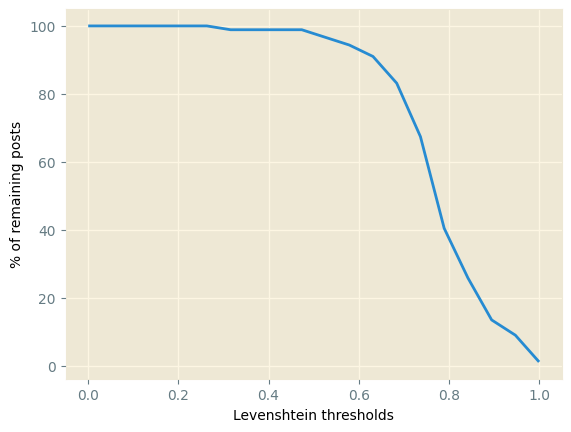

In [86]:
import matplotlib.pyplot as plt

fig = plt.figure()
with plt.style.context('Solarize_Light2'):
    plt.plot(x, y)
    plt.xlabel('Levenshtein thresholds')
    plt.ylabel('% of remaining posts')

In [59]:
def get_duplicates(
    corpus: list, 
    limit: float, 
    method: callable
    ):
    originals = []
    copies = []
    t = [utilities.clean_hashtag(s).strip() for s in corpus]
    distance = method #initialisiation de levenshtein avec la distance normalisée.
    i = 0
    r = len(t)
    while(i<r):
        r = len(t)
        j=i+1
        while(j<r):
            if(distance(t[i],t[j]) <= limit ): # Si la distance entre les deux élemens de la liste inf à seuil
                originals.append(t[i])
                copies.append([t[j]])
                break
            j+=1
        i+=1
    return pd.DataFrame({'originals' : originals , 'copies' : copies})

In [62]:
dist = textdistance.levenshtein.normalized_distance
originlas_copies = get_duplicates(corpus['text'].sample(n= 50, random_state = 42).tolist(),0.6,dist)

In [49]:
corpus_test.to_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/test_levenshtein.csv")

In [63]:
originlas_copies

,originals,copies
0,,[]
1,és,[ès]
2,"""🎈Welcome to my shop We have a lot of products...","[💕Welcome to my store, we sell all kinds of lu..."
3,ès,[és]
4,"I am a wholesaler of brand products, if you ne...","[""🎈I am a wholesaler of branded products, free..."
5,"24 hours customer service reply, we wholesale ...","[We have a professional customer service team,..."


In [7]:
def get_duplicates_per_thresholds():
    list_duplicates_per_thresholds = []
    list_thresholds = np.linspace(0.4,1,13)
    dist = textdistance.levenshtein.normalized_distance
    for thresholds in list_thresholds:
        list_duplicates_per_thresholds.append(get_duplicates(corpus['text'].sample(n= 50, random_state = 10).tolist(),thresholds,dist))
    return pd.DataFrame({'threshold' : list_thresholds , 'duplicates' : list_duplicates_per_thresholds})

In [9]:
df_dup_per_thesh = get_duplicates_per_thresholds()

In [11]:
df_dup_per_thesh

,threshold,duplicates
0,0.40,ori...
1,0.45,ori...
2,0.50,ori...
3,0.55,ori...
4,0.60,ori...
5,0.65,ori...
6,0.70,or...
7,0.75,or...
8,0.80,or...
9,0.85,or...


In [35]:
df_dup_per_thesh['duplicates'][4]

,originals,copies
0,"If you need my products, please add my whatsap...","[If you need my products, please add my whatsa..."
1,"Wholesale (shoes, clothes, hats, belts, etc.) ...","[Wholesale (shoes, clothes, hats, belts, etc.)..."
2,We are mainly engaged in various brands of sho...,[We are mainly engaged in various brands of sh...
3,,[]
4,"Hello friend, there are many products you need...","[Hello friend, there are many products you nee..."


### Optimisation paramètres de l'arbre de décision

In [6]:
chanel_junk_valid_new = pd.read_excel('C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel_junk_valid_new.xlsx')
chanel_junk_valid_new = chanel_junk_valid_new[['text','is_junk']].dropna()
chanel_junk_valid_new['has_URL'] = utilities.get_presence_of_URL(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['has_phone_number'] = utilities.get_presence_of_phone_numbers(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['has_currency_symbol'] = utilities.get_presence_of_currency_symbol(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['word_ratio'] = utilities.get_word_ratio(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new['caps_ratio'] = utilities.get_caps_ratio(corpus= chanel_junk_valid_new['text'], nlp= nlp)
chanel_junk_valid_new['norm_punct'] = utilities.get_normalized_nb_punct(corpus= chanel_junk_valid_new['text'], nlp= nlp  )
chanel_junk_valid_new = chanel_junk_valid_new.join(utilities.create_dummies(corpus= chanel_junk_valid_new['text'],y = chanel_junk_valid_new['is_junk'], element= 'emoji',nlp = nlp, top= 3))
chanel_all_features = chanel_junk_valid_new.join(utilities.create_dummies(corpus= chanel_junk_valid_new['text'],y = chanel_junk_valid_new['is_junk'], element= 'hashtag', nlp = nlp, top= 3))
X_train, X_test, y_train, y_test = train_test_split(chanel_all_features.dropna().drop(['text','is_junk'],axis=1), chanel_all_features.dropna()['is_junk'], test_size=0.30, random_state=42)

Arbre 1 : 

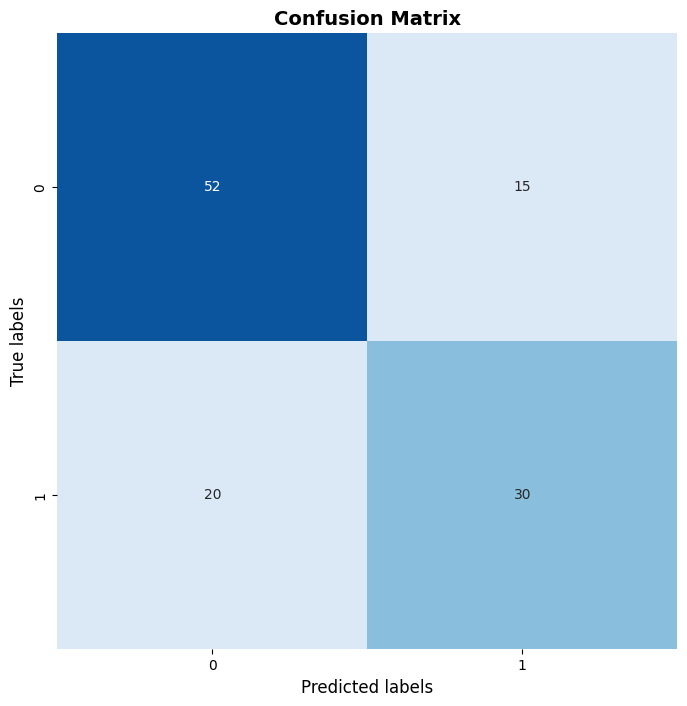

AUC : 0.6880597014925374
Accuracy score : 0.7008547008547008


In [42]:
tree1 = DecisionTreeClassifier(criterion = 'gini')
tree1.fit(X_train,y_train)
y_pred = tree1.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

Arbre 2

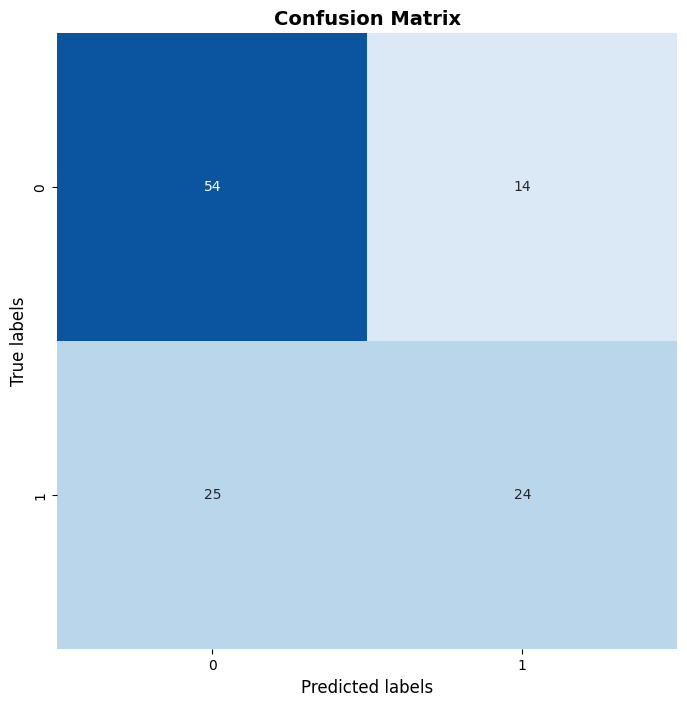

AUC : 0.6419567827130853
Accuracy score : 0.6666666666666666


In [61]:
tree2 = DecisionTreeClassifier(criterion = 'entropy')
tree2.fit(X_train,y_train)
y_pred = tree2.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

Arbre 3

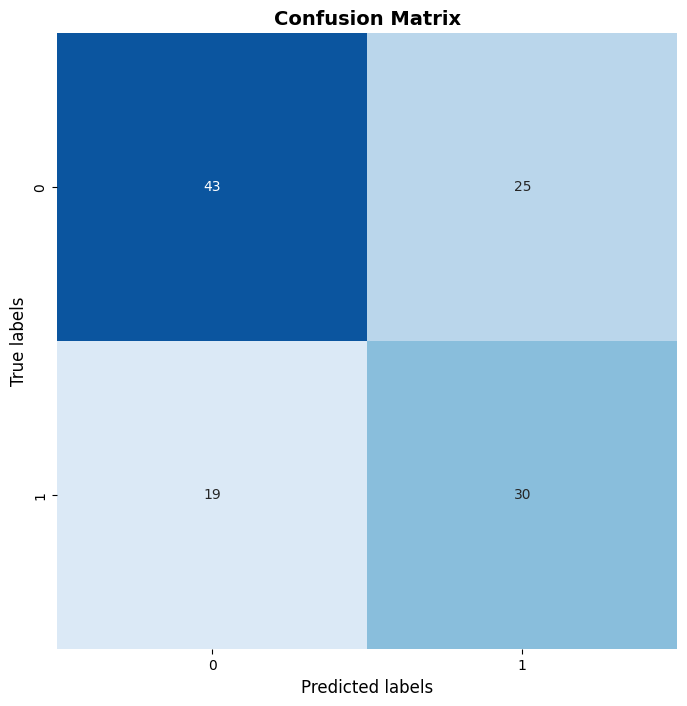

AUC : 0.6222989195678271
Accuracy score : 0.6239316239316239


In [67]:
tree3 = DecisionTreeClassifier(criterion = 'entropy',class_weight = "balanced")
tree3.fit(X_train,y_train)
y_pred = tree3.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

Arbre 4

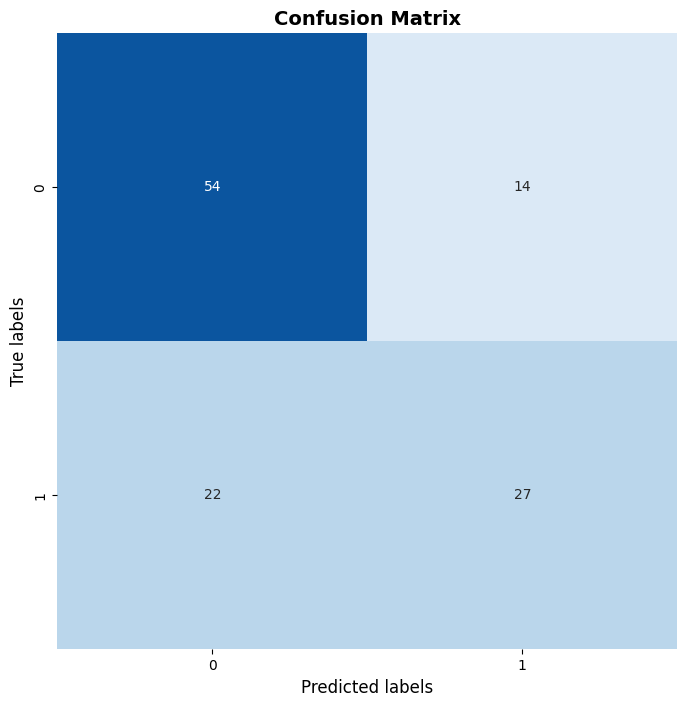

AUC : 0.6725690276110444
Accuracy score : 0.6923076923076923


In [37]:
tree4 = DecisionTreeClassifier(criterion = 'entropy', max_depth=10)
tree4.fit(X_train,y_train)
y_pred = tree4.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")

Arbre 5

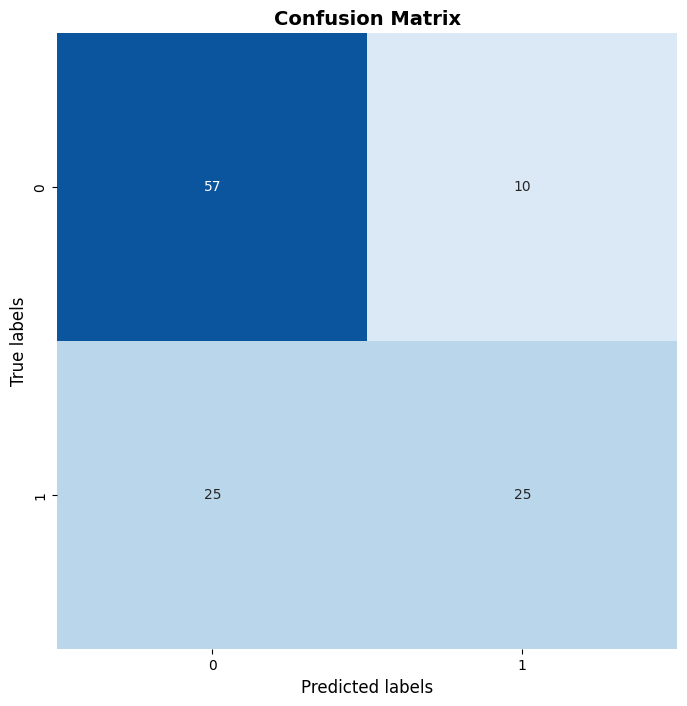

AUC : 0.6753731343283582
Accuracy score : 0.7008547008547008
Precision : 0.5
Recall    : 0.7142857142857143


In [4]:
tree5 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 9, ccp_alpha =  0.001, min_samples_leaf = 5, max_features = 11, min_samples_split = 5, random_state = 42)
tree5.fit(X_train,y_train)
y_pred = tree5.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")
print(f"Precision : {confusion_matrix(y_test, y_pred)[1][1]/(confusion_matrix(y_test, y_pred)[1][1]+confusion_matrix(y_test, y_pred)[1][0])}\nRecall    : {confusion_matrix(y_test, y_pred)[1][1]/(confusion_matrix(y_test, y_pred)[1][1]+confusion_matrix(y_test, y_pred)[0][1])}")


### Combinaison des trois paramètres 

Gridsearch

In [55]:
param_grid = {  'criterion': ['entropy'],
                'max_depth' : np.linspace(5,15,8, dtype= int),
                'ccp_alpha' : np.linspace(0,0.040,17),
                'min_samples_leaf' : np.linspace(1,15,7,dtype= int),
                'max_features' : np.linspace(5,15,6,dtype= int),
                'min_samples_split' : np.linspace(5,15,6,dtype= int)
                }  
   
grid = GridSearchCV(DecisionTreeClassifier(random_state = 42), param_grid, scoring = 'roc_auc' ,refit = True, verbose = 3,n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)

Fitting 5 folds for each of 34272 candidates, totalling 171360 fits
{'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 11, 'min_samples_leaf': 5, 'min_samples_split': 5}


Optimisaiton ccp

In [22]:
param_grid_ccp = {  'criterion': ['entropy'],
                    'max_depth' : np.linspace(5,15,10, dtype= int),
                    'ccp_alpha' : np.linspace(0.0,0.20,20),
                    'min_samples_leaf' : np.linspace(5,7,3,dtype= int),
                    'max_features' : np.linspace(7,11,3,dtype= int),
                    'min_samples_split' : np.linspace(4,6,3,dtype= int)
                    }  

   
grid_ccp = GridSearchCV(DecisionTreeClassifier(criterion = 'entropy', max_depth = 10, min_samples_leaf = 5, max_features = 9, min_samples_split = 5,random_state = 42), param_grid_ccp, scoring = 'recall' ,refit = True, verbose = 3,n_jobs=-1)
grid_ccp.fit(X_train, y_train)
print(grid_ccp.best_params_)


Fitting 5 folds for each of 101 candidates, totalling 505 fits
{'ccp_alpha': 0.006}


Final tree

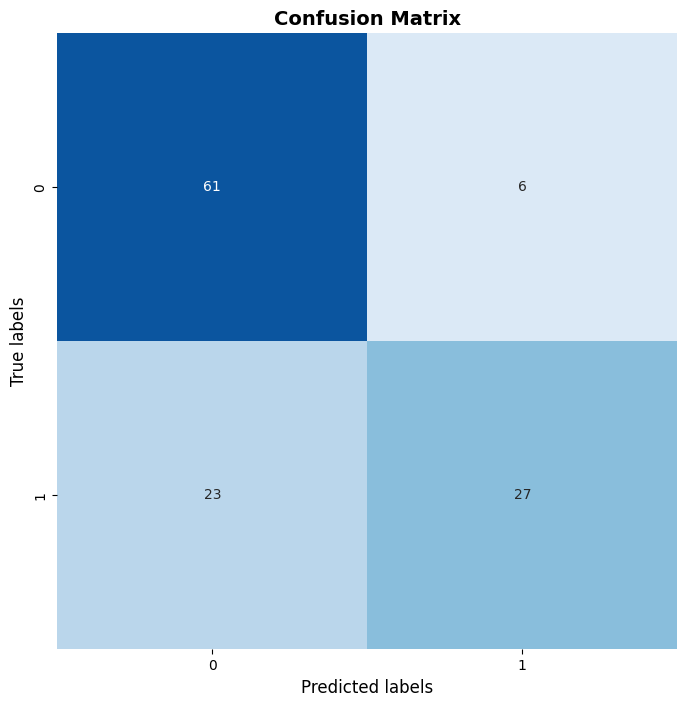

AUC : 0.7252238805970149
Accuracy score : 0.7521367521367521
Precision : 0.54
Recall    : 0.8181818181818182


In [7]:
tree_f = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10, ccp_alpha = 0.001, min_samples_leaf = 5, max_features = 9, min_samples_split = 5, random_state = 42)
tree_f.fit(X_train,y_train)
y_pred = tree_f.predict(X_test)
utilities.plot_confusion_matrix(y_true = y_test, y_pred = y_pred)
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
print(f"AUC : {metrics.auc(fpr, tpr)}")
print(f"Accuracy score : {metrics.accuracy_score(y_test, y_pred)}")
print(f"Precision : {confusion_matrix(y_test, y_pred)[1][1]/(confusion_matrix(y_test, y_pred)[1][1]+confusion_matrix(y_test, y_pred)[1][0])}\nRecall    : {confusion_matrix(y_test, y_pred)[1][1]/(confusion_matrix(y_test, y_pred)[1][1]+confusion_matrix(y_test, y_pred)[0][1])}")

Affichage arbre

[Text(0.44565217391304346, 0.95, 'has_phone_number <= 0.5\nentropy = 0.978\nsamples = 271\nvalue = [159, 112]\nclass = not junk'),
 Text(0.40217391304347827, 0.85, 'word_ratio <= 0.975\nentropy = 0.937\nsamples = 246\nvalue = [159, 87]\nclass = not junk'),
 Text(0.13043478260869565, 0.75, 'word_ratio <= 0.528\nentropy = 0.734\nsamples = 34\nvalue = [7, 27]\nclass = junk'),
 Text(0.08695652173913043, 0.65, 'entropy = 0.0\nsamples = 5\nvalue = [0, 5]\nclass = junk'),
 Text(0.17391304347826086, 0.65, 'caps_ratio <= 0.015\nentropy = 0.797\nsamples = 29\nvalue = [7, 22]\nclass = junk'),
 Text(0.08695652173913043, 0.55, 'word_ratio <= 0.923\nentropy = 0.94\nsamples = 14\nvalue = [5, 9]\nclass = junk'),
 Text(0.043478260869565216, 0.45, 'entropy = 0.65\nsamples = 6\nvalue = [1, 5]\nclass = junk'),
 Text(0.13043478260869565, 0.45, 'entropy = 1.0\nsamples = 8\nvalue = [4, 4]\nclass = not junk'),
 Text(0.2608695652173913, 0.55, 'caps_ratio <= 0.06\nentropy = 0.567\nsamples = 15\nvalue = [2, 13]\

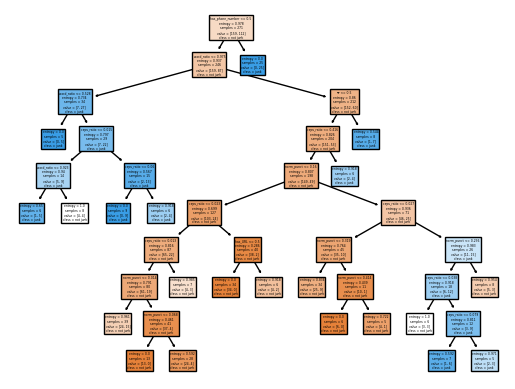

In [6]:
sklearn.tree.plot_tree(tree_f,feature_names = X_train.columns, class_names = ['not junk','junk'], filled = True)

ROC

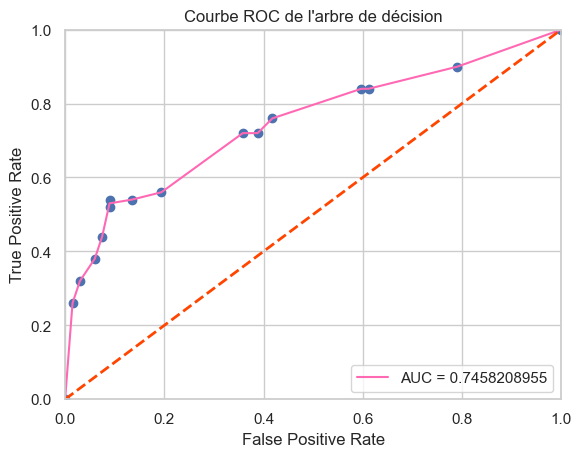

In [8]:
# Calcul des valeurs TPR et FPR
y_score = tree_f.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = metrics.auc(fpr, tpr)

# Tracé de la courbe ROC avec seaborn
sns.set(style='whitegrid', font_scale=1)
sns.lineplot(x=fpr, y=tpr, color='hotpink', label=f'AUC = {roc_auc:.10f}')
plt.plot([0, 1], [0, 1], color='orangered', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC de l\'arbre de décision')
plt.legend(loc='lower right')
plt.scatter(fpr,tpr)
plt.show()

In [9]:
fpr

array([0.        , 0.01492537, 0.02985075, 0.05970149, 0.07462687,
       0.08955224, 0.08955224, 0.13432836, 0.19402985, 0.35820896,
       0.3880597 , 0.41791045, 0.59701493, 0.6119403 , 0.79104478,
       1.        ])

In [110]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [171]:
metrics.confusion_matrix(y_test, y_pred)[1][0]

23